### DEMDP11

# Monetary Policy Model

A central bank must set nominal interest rate so as to minimize deviations of inflation rate and GDP gap from established targets.

A monetary authority wishes to control the nominal interest rate $x$ in order to minimize the variation of the inflation rate $s_1$ and the gross domestic product (GDP) gap $s_2$ around specified targets $s^∗_1$ and $s^∗_2$, respectively. Specifically, the authority wishes to minimize expected discounted stream of weighted squared deviations

\begin{equation}
L(s) = \frac{1}{2}(s − s^∗)'\Omega(s − s^∗)
\end{equation}

where $s$ is a $2\times 1$ vector containing the inflation rate and the GDP gap, $s^∗$ is a $2\times 1$ vector of  targets, and $\Omega$ is a $2 \times 2$ constant positive definite matrix of preference weights. The inflation rate and the GDP gap are a joint controlled exogenous linear Markov process

\begin{equation}
s_{t+1} = \alpha + \beta s_t + \gamma x_t + \epsilon_{t+1}
\end{equation}

where $\alpha$ and $\gamma$ are $2 \times 1$ constant vectors, $\beta$ is a $2 \times 2$ constant matrix, and $\epsilon$ is a $2 \times 1$ random vector with mean zero. For institutional reasons, the nominal interest rate $x$ cannot be negative. **What monetary policy minimizes the sum of current and expected future losses?**

This is an infinite horizon, stochastic model with time $t$ measured in years. The state vector $s \in \mathbb{R}^2$
contains the inflation rate and the GDP gap. The action variable $x \in [0,\infty)$ is the nominal interest rate. The state transition function is $g(s, x, \epsilon) = \alpha + \beta s + \gamma x + \epsilon$

In order to formulate this problem as a maximization problem, one posits a reward function that equals the negative of the loss function $f(s,x) = −L(s)$

The sum of current and expected future rewards satisfies the Bellman equation

\begin{equation}
V(s) = \max_{0\leq x}\left\{-L(s) + \delta + E_\epsilon V\left(g(s,x,\epsilon)\right)\right\}
\end{equation}

Given the structure of the model, one cannot preclude the possibility that the nonnegativity constraint on the optimal nominal interest rate will be binding in certain states. Accordingly, the shadow-price function $\lambda(s)$ is characterized by the Euler conditions

\begin{align}
    \delta\gamma'E_\epsilon \lambda\left(g(s,x,\epsilon)\right) &= \mu \\
    \lambda(s) &= -\Omega(s-s^*) + \delta\beta'E_\epsilon \lambda\left(g(s,x,\epsilon)\right)
\end{align}

where the nominal interest rate $x$ and the long-run marginal reward $\mu$ from increasing the nominal interest rate must satisfy the complementarity condition
\begin{equation}
x \geq 0, \qquad \mu \leq 0, \qquad x > 0 \Rightarrow \mu = 0
\end{equation}

It follows that along the optimal path

\begin{align}
    \delta\gamma'E_\epsilon \lambda_{t+1} &= \mu_t \\
    \lambda_t &= -\Omega(s_t-s^*) + \delta\beta'E_\epsilon \lambda_{t+1}\\
    x \geq 0, \qquad \mu \leq 0, &\qquad x > 0 \Rightarrow \mu = 0
\end{align}

Thus, in any period, the nominal interest rate is reduced until either the long-run marginal

reward or the nominal interest rate is driven to zero.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from compecon import BasisChebyshev, DPmodel, BasisSpline, qnwnorm, demo
import pandas as pd
pd.set_option('display.float_format',lambda x: f'{x:.3f}')

### Model Parameters


In [2]:
α   = np.array([[0.9, -0.1]]).T             # transition function constant coefficients
β    = np.array([[-0.5, 0.2], [0.3, -0.4]])  # transition function state coefficients
γ   = np.array([[-0.1, 0.0]]).T             # transition function action coefficients
Ω   = np.identity(2)                        # central banker's preference weights
ξ   = np.array([[1, 0]]).T                  # equilibrium targets
μ   = np.zeros(2)                           # shock mean
σ   = 0.08 * np.identity(2),                # shock covariance matrix
δ   = 0.9                                   # discount factor

### State Space

There are two state variables: 'GDP gap' = $s_0\in[-2,2]$ and 'inflation'=$s_1\in[-3,3]$.

In [3]:
n = 21          
smin = [-2, -3] 
smax = [ 2,  3] 

basis = BasisChebyshev(n, smin, smax, method='complete',
                       labels=['GDP gap', 'inflation'])

### Action space

There is only one action variable x: the nominal interest rate, which must be nonnegative.

In [4]:
def bounds(s, i, j):
    lb  = np.zeros_like(s[0])
    ub  = np.full(lb.shape, np.inf)
    return lb, ub

### Reward Function

In [5]:
def reward(s, x, i, j):
    s = s - ξ
    f = np.zeros_like(s[0])
    for ii in range(2):
        for jj in range(2):
            f -= 0.5 * Ω[ii, jj] * s[ii] * s[jj]
    fx = np.zeros_like(x)
    fxx = np.zeros_like(x)
    return f, fx, fxx

### State Transition Function

In [6]:
def transition(s, x, i, j, in_, e):
    g = α + β @ s + γ @ x + e
    gx = np.tile(γ, (1, x.size))
    gxx = np.zeros_like(s)
    return g, gx, gxx

The continuous shock must be discretized. Here we use Gauss-Legendre quadrature to obtain nodes and weights defining a discrete distribution that matches the first 6 moments of the Normal distribution (this is achieved with m=3 nodes and weights) for each of the state variables.

In [7]:
m   = [3, 3]
[e,w] = qnwnorm(m,μ,σ)

### Model structure

In [8]:
bank = DPmodel(basis, reward, transition, bounds,
               x=['interest'], discount=δ, e=e, w=w)

Compute Unconstrained Deterministic Steady-State

In [9]:
bank_lq = bank.lqapprox(ξ,0)

sstar = bank_lq.steady['s']
xstar = bank_lq.steady['x']

If Nonnegativity Constraint Violated, Re-Compute Deterministic Steady-State

In [10]:
if xstar < 0:
    I = np.identity(2)
    xstar = 0.0
    sstar = np.linalg.solve(np.identity(2) - β, α)

frmt = '\t%-21s = %5.2f' 
print('Deterministic Steady-State')
print(frmt % ('GDP Gap', sstar[0]))
print(frmt % ('Inflation Rate', sstar[1]))
print(frmt % ('Nominal Interest Rate', xstar))

Deterministic Steady-State
	GDP Gap               =  0.61
	Inflation Rate        =  0.06
	Nominal Interest Rate =  0.00


### Solve the model
We solve the model by calling the `solve` method in `bank`. On return, `sol` is a pandas dataframe with columns *GDP gap*, *inflation*, *value*, *interest*, and *resid*. We set a refined grid `nr=5` for this output.

In [11]:
S = bank.solve(nr=5)

Solving infinite-horizon model collocation equation by Newton's method
iter change       time    
------------------------------
   0       6.7e+00    0.3994
   1       9.9e-01    1.1321
   2       9.1e-04    1.7787
   3       8.3e-07    2.2782
   4       7.7e-09    2.7687
Elapsed Time =    2.77 Seconds


To make the 3D plots, we need to reshape the columns of `sol`.

In [12]:
S3d = {x: S[x].reshape((5*n,5*n)) for x in S.columns}

This function will make all plots

In [13]:
def makeplot(series,zlabel,zticks,title):
    fig = plt.figure(figsize=[8,5])
    ax = fig.gca(projection='3d')
    ax.plot_surface(S3d['GDP gap'], S3d['inflation'], S3d[series], cmap=cm.coolwarm)
    ax.set_xlabel('GDP gap')
    ax.set_ylabel('Inflation')
    ax.set_zlabel(zlabel)  
    ax.set_xticks(np.arange(-2,3))
    ax.set_yticks(np.arange(-3,4))
    ax.set_zticks(zticks)
    ax.set_title(title)

###  Optimal policy

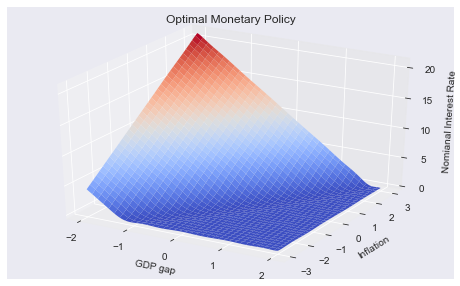

In [14]:
fig1 = makeplot('interest', 'Nomianal Interest Rate',
               np.arange(0,21,5),'Optimal Monetary Policy')

### Value function

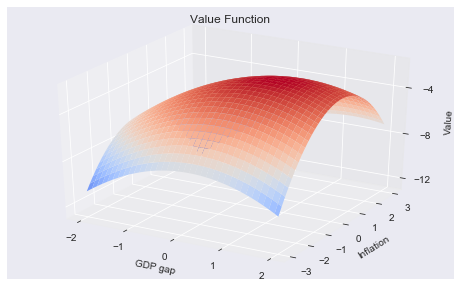

In [15]:
fig2 = makeplot('value','Value',
                np.arange(-12,S['value'].max(),4),'Value Function')

### Residuals

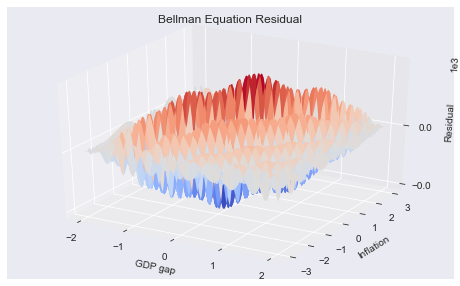

In [16]:
fig3 = makeplot('resid','Residual',
                [-1.5e-3, 0, 1.5e3],'Bellman Equation Residual')
plt.ticklabel_format(style='sci', axis='z', scilimits=(-1,1))

## Simulating the model

We simulate 21 periods of the model starting from $s=s_{\min}$, 10000 repetitions.

In [17]:
T = 21
nrep = 10_000
data = bank.simulate(T, np.tile(np.atleast_2d(smax).T,nrep))

In [18]:
subdata = data[data['time']==T][['GDP gap', 'inflation', 'interest']]
stats =pd.DataFrame({'Deterministic Steady-State': [*sstar.flatten(), xstar],
              'Ergodic Means': subdata.mean(),
              'Ergodic Standard Deviations': subdata.std()})
stats.T

,GDP gap,inflation,interest
Deterministic Steady-State,0.608,0.059,0.000
Ergodic Means,0.591,0.058,0.301
Ergodic Standard Deviations,0.315,0.334,0.694


### Simulated State and Policy Paths

In [19]:
subdata = data[data['_rep'].isin(range(3))]
opts = dict(spec='r*', offset=(0, -15), fs=11, ha='right')
gdpstar, infstar, intstar = stats['Ergodic Means']

def simplot(series,ylabel,yticks,steady):
    fig = demo.figure('Simulated and Expected ' + ylabel,'Period', ylabel,[0, T + 0.5])
    plt.plot(data[['time',series]].groupby('time').mean())
    plt.plot(subdata.pivot('time','_rep',series),lw=1)
    plt.xticks(np.arange(0,24,4))
    plt.yticks(yticks)
    demo.annotate(T, steady, f'Expected {series}\n = {steady:.2f}', **opts)
    return fig

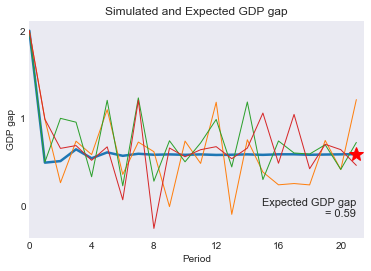

In [20]:
fig4 = simplot('GDP gap','GDP gap',np.arange(smin[0],smax[0]+1),gdpstar)

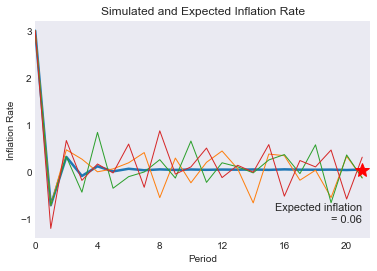

In [21]:
fig5 = simplot('inflation', 'Inflation Rate',np.arange(smin[1],smax[1]+1),infstar)

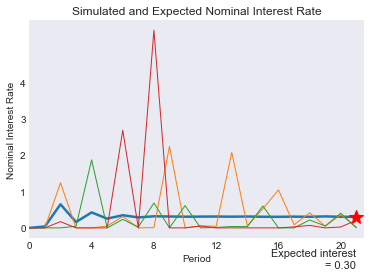

In [22]:
fig6 = simplot('interest','Nominal Interest Rate',np.arange(-2,5),intstar)

In [23]:
#demo.savefig([fig1,fig2,fig3,fig4,fig5,fig6])